In [1]:
import pandas as pd
import seaborn as sns
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re

import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib import rc
#palette = list(mcolors.TABLEAU_COLORS.keys())
#palette.extend(['salmon', 'teal','yellowgreen'])

import random
#from pyswarm import pso
import isocor

In [2]:
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
palette = sns.color_palette(as_cmap=True)
palette.extend(['salmon', 'teal','yellowgreen'])

In [4]:
sns.color_palette(palette)

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215),
 (0.9803921568627451, 0.5019607843137255, 0.4470588235294118),
 (0.0, 0.5019607843137255, 0.5019607843137255),
 (0.6039215686274509, 0.803921568627451, 0.19607843137254902)]

In [5]:
element_prob_dict = {
    'C_natural-U13C-Glc-Gln': 1-0.99401515,
    'C_enriched-U13C-Glc-Gln': 0.99401515,
    'C_natural-13C2-Asp': 1-0.99401515,
    'C_enriched-13C2-Asp': 0.99401515,
    'C_natural-U13C-Asn': 1-0.990724331,
    'C_enriched-U13C-Asn': 0.990724331,
}

In [6]:
metab_to_correct = {
    'Aspartate neg': {
        'ion_formula': 'C4H6NO4',
        'tracer_element': '13C',
        'charge': -1
    },
    'Fumarate neg': {
        'ion_formula': 'C4H3O4',
        'tracer_element': '13C',
        'charge': -1
    },
    'Malate neg': {
        'ion_formula': 'C4H5O5',
        'tracer_element': '13C',
        'charge': -1
    },
    'Glutamate neg': {
        'ion_formula': 'C5H8NO4',
        'tracer_element': '13C',
        'charge': -1
    },    
    'Glutamine pos': {
        'ion_formula': 'C5H11N2O3',
        'tracer_element': '13C',
        'charge': 1
    },
    'Asparagine pos': {
        'ion_formula': 'C4H9N2O3',
        'tracer_element': '13C',
        'charge': 1
    },
#    'Asparagine neg': {
#        'ion_formula': 'C4H7N2O3',
#        'tracer_element': '13C',
#        'charge': -1
#    }
}

In [7]:
annotation_df = pd.read_excel('annotations.xlsx')

In [10]:
### Read measurements

### Replace all N/F and N/A with 0 before start ###
esheet_dict_mes = pd.read_excel('data/Tcell_in-vivo_Asn-label_FACS-sorted-cells_1and2.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        sp = k[:-4].split()
        if len(sp) == 2:
            base, isotope = sp
        else:
            base, isotope = [sp[0], '13C0']
        metab_pol = base + k[-4:]
        
        metab_names_mes.append(metab_pol)
        
        df_tmp = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        df_tmp['Sample_name'] = df_tmp['Sample ID']
        #df_tmp['Mouse'] = [s.split('_')[0] for s in df_tmp['Sample ID']]
        #df_tmp['Sample_type'] = [s.split('_')[1] for s in df_tmp['Sample ID']]
        df_tmp['Compound'] = base
        #df_tmp['Tracer'] = ['U13C-Asn'] * len(df_tmp['Sample ID'])
        df_tmp['Compound_polarity'] = metab_pol
        df_tmp['Isotope'] = isotope
        df_tmp['Isotope_order'] = isotope[3:]
        # Placeholder
        df_tmp['Isotope_fraction'] = 0
        
        # Add annotations:
        df_tmp = df_tmp.merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        df_tmp = df_tmp.drop(['Type', 'Filename', 'Flag Details', 'Sample ID', 'ISTD Response'], axis=1)
        
        if metab_pol in metab_dict_mes:
            metab_dict_mes[metab_pol] = metab_dict_mes[metab_pol].append(df_tmp)
        else:
            metab_dict_mes[metab_pol] = copy.deepcopy(df_tmp)

In [11]:
metab_dict_mes['Aspartate neg']

,Compound,RT,Response,Formula,Response Ratio,Sample_name,Compound_polarity,Isotope,Isotope_order,Isotope_fraction,Mouse,Sample_type,Tracer,Replicate
0,Aspartate,10.4,1207756,[13]CC3H7NO4,0,5800_gpASNase,Aspartate neg,13C1,1,0,5800,gpASNase,U13C-Asn,2
1,Aspartate,10.4,645539,[13]CC3H7NO4,0,5800_msASNase,Aspartate neg,13C1,1,0,5800,msASNase,U13C-Asn,1
2,Aspartate,10.4,1127320,[13]CC3H7NO4,0,5805_gpASNase,Aspartate neg,13C1,1,0,5805,gpASNase,U13C-Asn,2
3,Aspartate,10.4,227816,[13]CC3H7NO4,0,5805_msASNase,Aspartate neg,13C1,1,0,5805,msASNase,U13C-Asn,1
4,Aspartate,10.4,1140957,[13]CC3H7NO4,0,5836_gpASNase,Aspartate neg,13C1,1,0,5836,gpASNase,U13C-Asn,2
5,Aspartate,10.4,275973,[13]CC3H7NO4,0,5836_msASNase,Aspartate neg,13C1,1,0,5836,msASNase,U13C-Asn,1
0,Aspartate,10.4,1912773,[13]C2C2H7NO4,0,5800_gpASNase,Aspartate neg,13C2,2,0,5800,gpASNase,U13C-Asn,2
1,Aspartate,10.4,97989,[13]C2C2H7NO4,0,5800_msASNase,Aspartate neg,13C2,2,0,5800,msASNase,U13C-Asn,1
2,Aspartate,10.4,2146821,[13]C2C2H7NO4,0,5805_gpASNase,Aspartate neg,13C2,2,0,5805,gpASNase,U13C-Asn,2
3,Aspartate,10.4,39157,[13]C2C2H7NO4,0,5805_msASNase,Aspartate neg,13C2,2,0,5805,msASNase,U13C-Asn,1


In [12]:
for metab_pol in set(metab_names_mes):
    if metab_pol not in metab_to_correct:
        continue
    
    metab_dict_mes[metab_pol] = metab_dict_mes[metab_pol].sort_values(by=['Isotope_order', 'Sample_name'])
    for sn in set(metab_dict_mes[metab_pol]['Sample_name'].values):
        sn_mask = metab_dict_mes[metab_pol]['Sample_name'] == sn
        tracer = metab_dict_mes[metab_pol].loc[sn_mask, 'Tracer'].values[0]
        obs_mid = metab_dict_mes[metab_pol].loc[sn_mask, 'Response'].values

        ion_formula = metab_to_correct[metab_pol]['ion_formula']
        charge = metab_to_correct[metab_pol]['charge']
        tracer_element = metab_to_correct[metab_pol]['tracer_element']
        tracer_purity = [element_prob_dict['C_natural-{}'.format(tracer)], element_prob_dict['C_enriched-{}'.format(tracer)]]

        corrector_HR = isocor.mscorrectors.MetaboliteCorrectorFactory(formula=ion_formula, label=metab_pol, tracer=tracer_element, tracer_purity=tracer_purity, resolution=240000, mz_of_resolution=200, charge=charge, correct_NA_tracer=True, resolution_formula_code='orbitrap')

        # Calculate the corrected isotope fraction:
        corrected_area, iso_fraction, res, m_enr = corrector_HR.correct(obs_mid)
        metab_dict_mes[metab_pol].loc[sn_mask, 'Isotope_fraction'] = iso_fraction
        metab_dict_mes[metab_pol]= metab_dict_mes[metab_pol].fillna(0)
    

In [13]:
metab_dict_mes_mean = dict()
metab_dict_mes_stdev = dict()

for base in set(metab_names_mes):
    metab_dict_mes_mean[base] = metab_dict_mes[base].groupby(['Sample_type', 'Isotope', 'Tracer', 'Isotope_order']).mean().reset_index().drop(['Response', 'RT', 'Replicate'], axis=1)
    metab_dict_mes_stdev[base] = metab_dict_mes[base].groupby(['Sample_type', 'Isotope', 'Tracer', 'Isotope_order']).std().reset_index().drop(['Response', 'RT', 'Replicate'], axis=1)



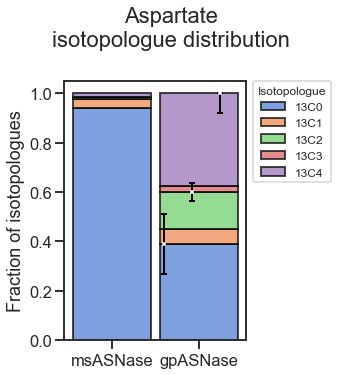

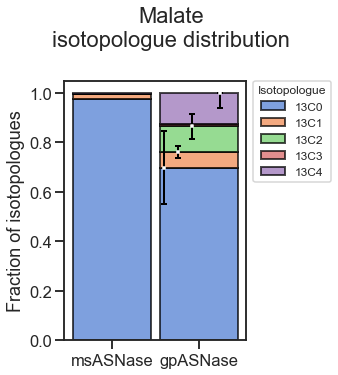

In [15]:
### Plot isotopologue distribution ###

tracer_list = ['U13C-Asn']
tracer_list_name = ['U-$^{13}$C Asn']
sample_list = ['msASNase', 'gpASNase']

width = 0.9           # the width of the bars: can also be len(x) sequence
ind = np.arange(len(sample_list))


for base in list(set(metab_names_mes)):
    if base not in metab_to_correct:
        continue
    
    Nplots = 0
    for tracer in tracer_list:
        mask = metab_dict_mes_mean[base]['Tracer'] == tracer
        if metab_dict_mes_mean[base][mask]['Isotope_fraction'].sum() > 0:
            Nplots += 1
    if Nplots == 1:
        fig, ax = plt.subplots(1, 1, figsize=(5.1, 5.4), sharey=True)
        ax_list = [ax]
    else:
        fig, ax_list = plt.subplots(1, 2, figsize=(8, 5.4), sharey=True)
    
    ax_idx = 0
    for tracer_idx, tracer in enumerate(tracer_list):
        plot_objs = []
        mask = metab_dict_mes_mean[base]['Tracer'] == tracer
        # Sorting makes sure that gpASNase comes before msASNase. 
        df_tmp = metab_dict_mes_mean[base][mask].sort_values('Sample_type', ascending=False)
        if df_tmp['Isotope_fraction'].sum() == 0:
            continue
        df_tmp_stdev = metab_dict_mes_stdev[base][mask].sort_values('Sample_type', ascending=False)
        area_sum = np.zeros(len(sample_list))
        isotope_name_list = sorted(list(set(df_tmp['Isotope'].values)), key=lambda x: int(x[3:]))
        Niso = len(isotope_name_list)
        err_space = 0.8/Niso
        for i, isotope in enumerate(isotope_name_list):
            iso_mask = df_tmp['Isotope'] == isotope
            isotope_fraction_list = df_tmp[iso_mask]['Isotope_fraction'].values
            #### Determine error bar ####
            yerr_1N = df_tmp_stdev[iso_mask]['Isotope_fraction'].values
            yerr_low = list()
            yerr_high = list()
            for err_i, yerr in enumerate(yerr_1N):
                yerr_new = list()
                bar_height = isotope_fraction_list[err_i] + area_sum[err_i]
                # No errorbar smaller than 0:
                if (bar_height - yerr) < 0:
                    yerr_low.append(bar_height)
                else:
                    yerr_low.append(yerr)
                # No errorbar larger than 1:
                if (yerr + bar_height) > 1:
                    yerr_high.append(1 - bar_height)
                else:
                    yerr_high.append(yerr)
            yerr_2N = [yerr_low, yerr_high]
            #############
            
            p = ax_list[ax_idx].bar(ind, isotope_fraction_list, width, bottom=area_sum, color=palette[i], edgecolor='black', linewidth=2, alpha=0.7)
            plot_objs.append(p)
            area_sum += isotope_fraction_list
            # Shift errorbar on x-axis:
            err_x = ind - 0.4 + i * err_space
            for dot_idx, (err_l, err_h) in enumerate(zip(*yerr_2N)):
                # Only plot errorbar and dot if more than 2% error:
                if max([err_l, err_h])  > 0.02:
                    errbar_dots = ax_list[ax_idx].scatter(err_x[dot_idx], area_sum[dot_idx], s=8, marker='s', c='white', zorder=999)
                    errbar = ax_list[ax_idx].errorbar(err_x[dot_idx], area_sum[dot_idx], yerr=[[err_l],[err_h]], xerr=None, ecolor='black', lw=2, capsize=3, capthick=2, ls='none')


        ax_list[ax_idx].set_ylim([0, 1.05])
        ax_list[ax_idx].set_xticks(ind)
        ax_list[ax_idx].set_xticklabels(sample_list)
        #ax_list[ax_idx].set_title('Tracer: {}'.format(tracer_list_name[tracer_idx]))
        if ax_idx == 0:
            ax_list[ax_idx].set_ylabel('Fraction of isotopologues')
        ax_idx += 1
    
    ax_list[ax_idx-1].legend([p[1] for p in plot_objs], list(map(str, isotope_name_list)), loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12)

    if Nplots == 1:
        fig.suptitle('{}\nisotopologue distribution'.format(base[:-4]), size=22)
    else:
        fig.suptitle('{} isotopologue distribution'.format(base[:-4]), size=22)
    #fig.text(0.47, 0.01, 'GOT DKO clone', ha='center')
    plt.tight_layout()
    plt.savefig('plots/{}_isotopologue_distribution_FACS-sorted-cells.pdf'.format(base))
    plt.show();